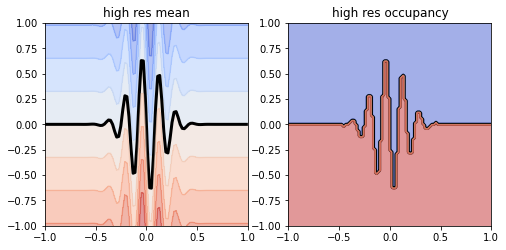

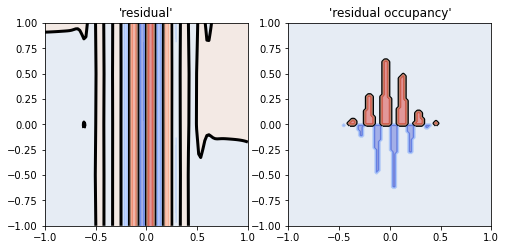

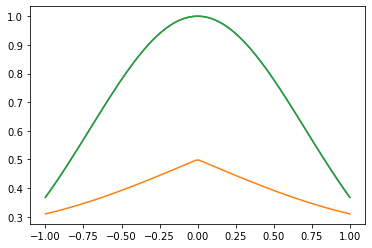

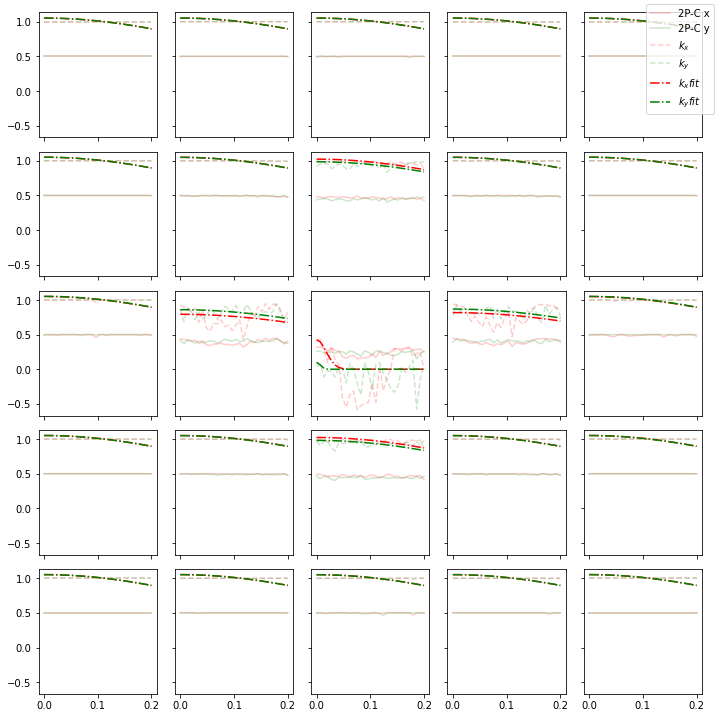

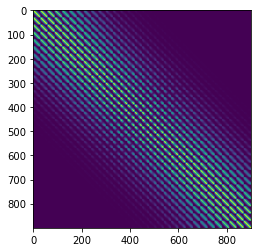

ValueError: the input matrix must be positive semidefinite

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import scipy.stats as stats
import scipy.optimize as opt

import utils

xrange = (-1, 1)
yrange = (-1, 1)

def mean(x,y):
    return np.sin(x*np.pi*12) * np.exp(-20 *np.power(x, 2)) * 0.7 + y
    #return np.sin(x*np.pi*8) * 0.4 + y


xs = np.linspace(*xrange, 100)
ys = np.linspace(*yrange, 100)
xx, yy = np.meshgrid(xs, ys)

fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].set_title("high res mean")
utils.plot_realization(mean(xx,yy), axs[0], xx, yy)

axs[1].set_title("high res occupancy")
utils.plot_realization( -((mean(xx,yy) < 0) - 0.5), axs[1], xx, yy)

disc_res = 5
disc_samples = 5000
disc_x = np.linspace(*xrange, disc_res)
disc_y = np.linspace(*yrange, disc_res)
disc_mean = np.zeros((disc_res,disc_res))
filter_width_x = 0.5*(xrange[1] - xrange[0])/disc_res
filter_width_y = 0.5*(yrange[1] - yrange[0])/disc_res

disc_occ = np.zeros((disc_res,disc_res))

for i, x in enumerate(disc_x):
    for j, y in enumerate(disc_y):
        disc_mean[i,j] = 0
        disc_occ[i,j] = 0
        for s in range(disc_samples):
            px = x + np.random.normal(0, 1) * filter_width_x
            py = y + np.random.normal(0, 1) * filter_width_y
            m = mean(px,py)
            disc_mean[i,j] += m
            disc_occ[i,j] += int(m > 0) - 0.5
        disc_mean[i,j] /= disc_samples
        disc_occ[i,j] /= disc_samples

grid_interp = interp.RegularGridInterpolator((disc_x, disc_y), disc_mean, "linear") 

grid_occ_interp = interp.RegularGridInterpolator((disc_x, disc_y), disc_occ, "linear") 


interp_mean = grid_interp((xx,yy))


fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].set_title("'residual'")
utils.plot_realization(interp_mean-mean(xx,yy), axs[0], xx, yy)

axs[1].set_title("'residual occupancy'")
utils.plot_realization( np.array(interp_mean < 0, dtype="int")-np.array(mean(xx,yy)< 0, dtype="int"), axs[1], xx, yy)


def orthant_prob(k):
    return np.arccos(-k) / (np.pi*2)

def inverse_orthant_prob(orth):
    return -np.cos(2*np.pi*orth)

fig, ax = plt.subplots()
ax.plot(xs, np.exp(-xs**2))
ax.plot(xs, orthant_prob(np.exp(-xs**2)))
ax.plot(xs, inverse_orthant_prob(orthant_prob(np.exp(-xs**2))))

tpc_size = 30


tpc_fig, tpc_axs = plt.subplots(disc_res,disc_res, figsize=(10,10), sharex=True, sharey=True)


def res_occ(px,py):
    return np.array(grid_interp((px,py)) < 0, dtype="int")-np.array(mean(px,py)< 0, dtype="int")

def kernel_fit(l, sigma, alpha, w, ls):
    return sigma * np.exp(-l**2/ls**2) # + alpha * np.exp(-2 * (np.sin(np.pi *l *w)**2)/(ls**2))


kernel_params_x = np.zeros((disc_res,disc_res,4))
kernel_params_y = np.zeros((disc_res,disc_res,4))

for i, x in enumerate(disc_x):
    for j, y in enumerate(disc_y):
        valid_samples = 0
        tpc_x = np.zeros(tpc_size)
        tpc_x_sc = np.zeros(tpc_size)
        tpc_y = np.zeros(tpc_size)
        tpc_y_sc = np.zeros(tpc_size)

        for s in range(disc_samples):
            p1x = x + np.random.uniform(-1, 1) * filter_width_x
            p1y = y + np.random.uniform(-1, 1) * filter_width_y
            if p1x < xrange[0] or p1x > xrange[1] or p1y < yrange[0] or p1y > yrange[1]:
                continue

            p2x = p1x + np.random.normal(0, 1) * filter_width_x
            p2y = p1y + np.random.normal(0, 1) * filter_width_y
            if p2x < xrange[0] or p2x > xrange[1] or p2y < yrange[0] or p2y > yrange[1]:
                continue

            pdx = p2x - p1x
            pdy = p2y - p1y
            ld = np.sqrt(pdx*pdx + pdy*pdy)

            p1_occ = res_occ(p1x, p1y)
            p2_occ = res_occ(p2x, p2y)

            same = int( np.abs(p1_occ - p2_occ) < 0.001)

            idx_x = int(np.clip(tpc_size*np.abs(pdx) / (filter_width_x), 0, tpc_size-1))
            idx_y = int(np.clip(tpc_size*np.abs(pdy) / (filter_width_y), 0, tpc_size-1))

            tpc_x[idx_x] += same / 2
            tpc_x_sc[idx_x] += 1
            tpc_y[idx_y] += same / 2
            tpc_y_sc[idx_y] += 1

            #occ = int(mean(px,py) < 0) - int(grid_interp((px,py)) < 0)
            #occ = mean(px,py) - grid_interp((px,py))
            #nl = np.sqrt(px*px + py*py)

            #occ_samples_x[valid_samples] = occ * np.abs(px/nl)
            #occ_samples_y[valid_samples] = occ * np.abs(py/nl)
            valid_samples += 1
        
        tpc_x /= np.maximum(tpc_x_sc, 1)
        tpc_y /= np.maximum(tpc_y_sc, 1)

        xs_hist = np.linspace(0, filter_width_x, tpc_size)
        ys_hist = np.linspace(0, filter_width_y, tpc_size)
        tpc_axs[i,j].plot(xs_hist, np.clip(tpc_x, 0, 10), label="2P-C x", color="red", alpha=0.2)
        tpc_axs[i,j].plot(ys_hist, np.clip(tpc_y, 0, 10), label="2P-C y", color="green", alpha=0.2)

        k_x = inverse_orthant_prob(tpc_x)
        k_y = inverse_orthant_prob(tpc_y)

        tpc_axs[i,j].plot(xs_hist, k_x, label="$k_x$", color="red", linestyle="--", alpha=0.2)
        tpc_axs[i,j].plot(ys_hist, k_y, label="$k_y$", color="green", linestyle="--", alpha=0.2)

        k_x_params, _ = opt.curve_fit(kernel_fit, xs_hist, k_x, bounds=([0.1,0,0,0.01],[10, np.inf, np.inf, 0.5]))
        k_y_params, _ = opt.curve_fit(kernel_fit, ys_hist, k_y, bounds=([0.1,0,0,0.01],[10, np.inf, np.inf, 0.5]))

        tpc_axs[i,j].plot(xs_hist, kernel_fit(xs_hist, *k_x_params), label="$k_x fit$", color="red", linestyle="-.")
        tpc_axs[i,j].plot(ys_hist, kernel_fit(ys_hist, *k_y_params), label="$k_y fit$", color="green", linestyle="-.")

        kernel_params_x[i,j] = k_x_params
        kernel_params_y[i,j] = k_y_params


handles, labels = tpc_axs[0,0].get_legend_handles_labels()
tpc_fig.legend(handles, labels, loc='upper right')
tpc_fig.tight_layout()

kernel_params_x_interp = interp.RegularGridInterpolator((disc_x, disc_y), kernel_params_x, "linear")
kernel_params_y_interp = interp.RegularGridInterpolator((disc_x, disc_y), kernel_params_y, "linear") 

def k(x0,y0,x1,y1):

    p0x = np.moveaxis(kernel_params_x_interp((x0,y0)), -1, 0)
    p0y = np.moveaxis(kernel_params_y_interp((x0,y0)), -1, 0)
    p1x = np.moveaxis(kernel_params_x_interp((x1,y1)), -1, 0)
    p1y = np.moveaxis(kernel_params_y_interp((x1,y1)), -1, 0)

    #p0x = np.moveaxis(kernel_params_x_interp((np.zeros_like(x0),np.zeros_like(y0))), -1, 0)
    #p1x = np.moveaxis(kernel_params_x_interp((np.zeros_like(x1),np.zeros_like(y1))), -1, 0)


    dx = np.abs(x0-x1)
    dy = np.abs(y0-y1)

    ln = np.sqrt(dx*dx + dy*dy)

    return 0.5*(kernel_fit(ln, *p0x) + kernel_fit(ln, *p1x))
                
    #return 0.5*(kernel_fit(dx, *p0x) * kernel_fit(dy, *p0y) + 
    #            kernel_fit(dx, *p1x) * kernel_fit(dy, *p1y))

def m(x0,y0):
    return grid_interp((x0,y0))

def mean_and_cov(xs,ys):
    M = m(xs, ys)
    x0s, x1s = np.meshgrid(xs, xs)
    y0s, y1s = np.meshgrid(ys, ys)
    K = k(x0s, y0s, x1s, y1s)
    return M, K


real_res = 30
real_x = np.linspace(*xrange, real_res)
real_y = np.linspace(*yrange, real_res)
real_xx, real_yy = np.meshgrid(real_x, real_y)

M, K = mean_and_cov(real_xx.ravel(), real_yy.ravel())

Kimg = K.reshape(real_res*real_res, real_res*real_res)
plt.show()
plt.imshow(Kimg)
plt.show()

dist = stats.multivariate_normal(M, K, allow_singular=True)
samples = dist.rvs(4)

fig, axs = plt.subplots(1, samples.shape[0], figsize=(samples.shape[0]*4, 4))
for i in range(samples.shape[0]):
    utils.plot_realization(samples[i].reshape(real_res, real_res), axs[i], real_xx, real_yy)


fig_occ, axs_occ = plt.subplots(1,4, figsize=(16,4))
axs_occ[0].set_title("downsampled mean (linear interp)")
utils.plot_realization(interp_mean, axs_occ[0], xx, yy)
axs_occ[0].grid(True, "major", "both")
axs_occ[0].set_xticks(disc_x)
axs_occ[0].set_yticks(disc_y)

axs_occ[1].set_title("occupancy based on downsampled mean")
utils.plot_realization( -((interp_mean < 0) - 0.5), axs_occ[1], xx, yy)
axs_occ[1].grid(True, "major", "both")
axs_occ[1].set_xticks(disc_x)
axs_occ[1].set_yticks(disc_y)

axs_occ[2].set_title("downsampled occupancy (linear interp)")
utils.plot_realization(grid_occ_interp((xx,yy)), axs_occ[2], xx, yy)
axs_occ[2].grid(True, "major", "both")
axs_occ[2].set_xticks(disc_x)
axs_occ[2].set_yticks(disc_y)
var = k(real_xx.ravel(), real_yy.ravel(), real_xx.ravel(), real_yy.ravel())
ptwise_occupancy = stats.norm.cdf(np.zeros_like(M), loc=M, scale=var*100+0.0001) - 0.5
axs_occ[3].set_title("Pointwise GP Occupancy")
utils.plot_realization(-ptwise_occupancy.reshape(real_res, real_res), axs_occ[3], real_xx, real_yy)
fig_occ.tight_layout()
    
